In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import shutil

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("wenewone/cub2002011")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cub2002011


#Data Pre-processing

In [ ]:
dataset_dir = "/kaggle/input/cub2002011"
img_dir = os.path.join(dataset_dir, "CUB_200_2011/images")

# Load images.txt (image_id and file path)
images_df = pd.read_csv(os.path.join(dataset_dir, "CUB_200_2011/images.txt"), sep=" ", names=["img_id", "filename"])
images_df["filename_only"] = images_df["filename"].apply(lambda x: os.path.basename(x))

# Load image_class_labels.txt
labels_df = pd.read_csv(os.path.join(dataset_dir, "CUB_200_2011/image_class_labels.txt"), sep=" ", names=["img_id", "class_label"])
labels_df["class_label"] -= 1  # Make 0-based

# Load classes.txt (class_label to class_name)
classes_df = pd.read_csv(os.path.join(dataset_dir, "CUB_200_2011/classes.txt"), sep=" ", names=["class_label", "raw_class_name"])
classes_df["class_label"] -= 1
classes_df["class_name"] = classes_df["raw_class_name"].apply(lambda x: x.split('.', 1)[-1])

# Merge all
df = images_df.merge(labels_df, on="img_id").merge(classes_df, on="class_label")
df = df[["filename_only", "class_name", "class_label"]]
df.rename(columns={"filename_only": "filename"}, inplace=True)

# Convert class_label to string for Keras
df["class_label"] = df["class_label"].astype(str)

In [ ]:
#Show all rows
pd.set_option('display.max_rows', None)

In [ ]:
#Get unique class name and class_label in a df
unique_classes = df[['class_name', 'class_label']].drop_duplicates()
unique_classes.head()

class_name class_label
0    Black_footed_Albatross           0
60         Laysan_Albatross           1
120         Sooty_Albatross           2
178       Groove_billed_Ani           3
238          Crested_Auklet           4

In [ ]:
# Split into train (70%) and temp (30%)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["class_label"], random_state=42)

# Split temp into validation (15%) and test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["class_label"], random_state=42)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")


Train size: 8251, Validation size: 1768, Test size: 1769


In [ ]:
#Save train, val, test
train_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Applied_ML_Assignment01/train.csv', index=False)
val_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Applied_ML_Assignment01/val.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Applied_ML_Assignment01/test.csv', index=False)

In [ ]:
train_df.head()

filename         class_name class_label
8734     Brown_Thrasher_0132_155337.jpg     Brown_Thrasher         148
8897  Blue_Headed_Vireo_0002_156241.jpg  Blue_headed_Vireo         151
5069             Mallard_0109_76616.jpg            Mallard          86
570       Rusty_Blackbird_0120_6762.jpg    Rusty_Blackbird          10
5590       Hooded_Oriole_0077_90886.jpg      Hooded_Oriole          95

In [ ]:
flat_dir = "/kaggle/working/images_flattened"
os.makedirs(flat_dir, exist_ok=True)

for subdir, _, files in os.walk(img_dir):
    for file in files:
        src_path = os.path.join(subdir, file)
        dst_path = os.path.join(flat_dir, file)
        if not os.path.exists(dst_path):
            shutil.copy2(src_path, dst_path)

In [ ]:
epoch = 100
batch_size = 32
img_size = (224, 224)
num_classes = 200

In [ ]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for val/test
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# get train_datset
train_dataset = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=flat_dir,
    x_col="filename",
    y_col="class_label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 8251 validated image filenames belonging to 200 classes.


In [ ]:
#get val_dataset
val_dataset = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=flat_dir,
    x_col="filename",
    y_col="class_label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 1768 validated image filenames belonging to 200 classes.


In [ ]:
#get test_dataset
test_dataset = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=flat_dir,
    x_col="filename",
    y_col="class_label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 1769 validated image filenames belonging to 200 classes.


#Visualising the data

In [ ]:
def plot_sample(data_file):
  X_batch, y_batch = data_file[0]
  # Show the first 10 images from the batch
  plt.figure(figsize=(15, 5))
  for i in range(10):
      ax = plt.subplot(2, 5, i + 1)
      plt.imshow(X_batch[i])
      plt.title(f"Label: {np.argmax(y_batch[i])}")
      plt.axis("off")
  plt.tight_layout()
  plt.show()


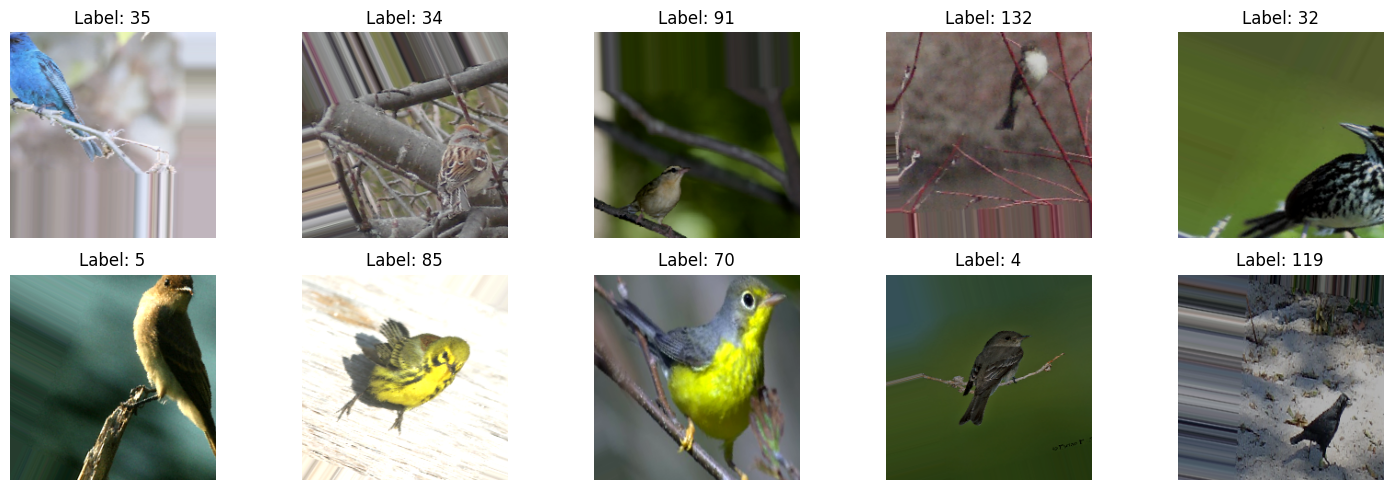

In [ ]:
plot_sample(train_dataset)

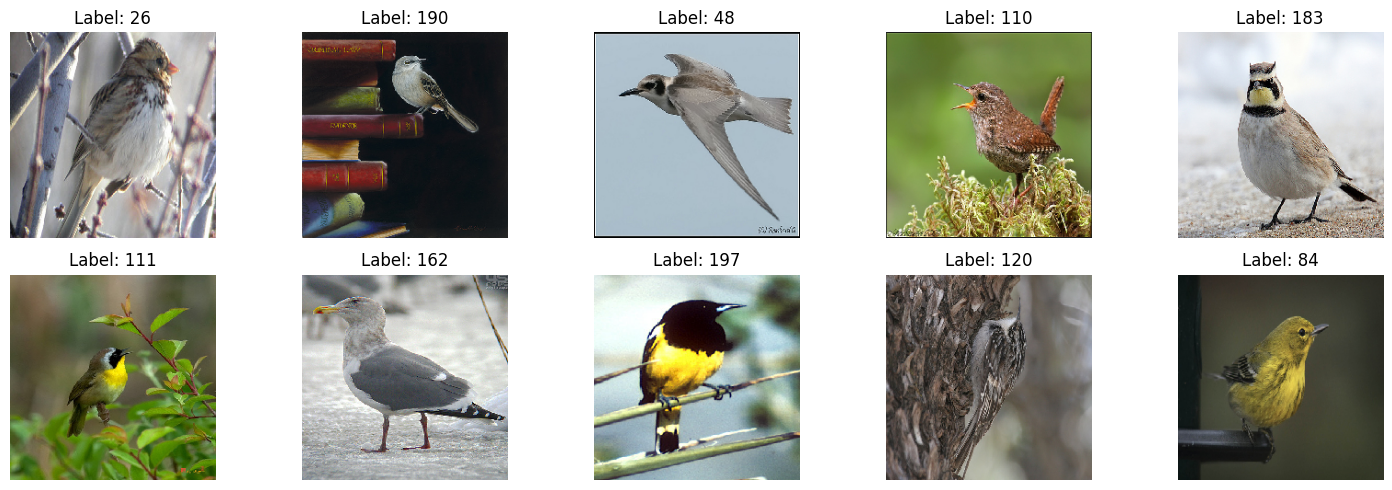

In [ ]:
plot_sample(val_dataset)

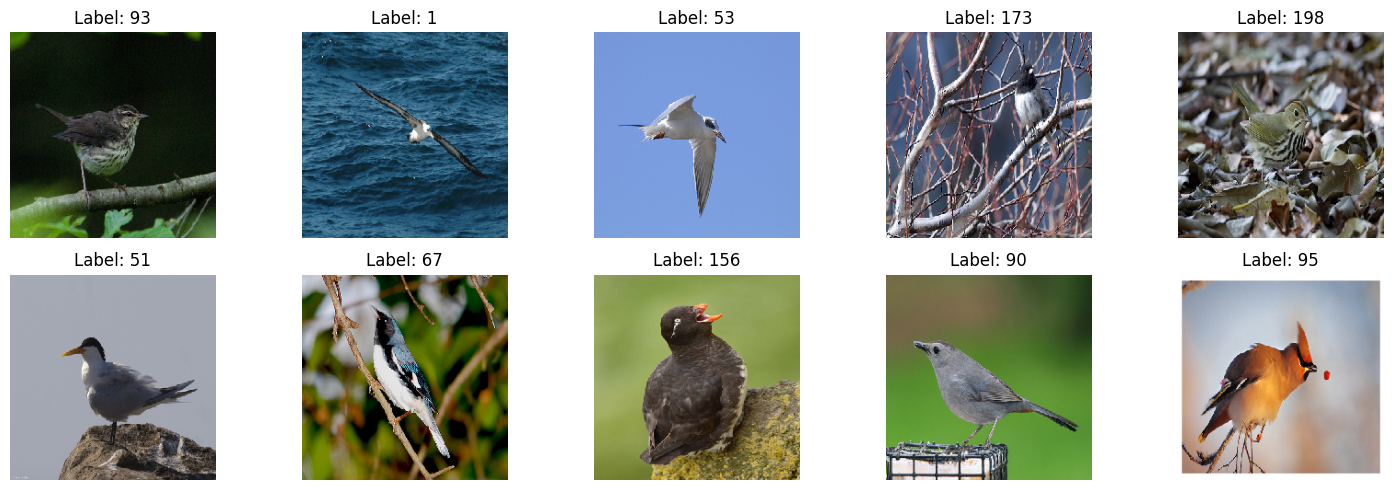

In [ ]:
plot_sample(test_dataset)

#Set up funciton to visualise training

In [ ]:
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g--', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.ylim([0, 1])
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'g--', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


#ResNet50

In [ ]:
def build_resnet50_model(input_shape=(224, 224, 3), num_classes=200, freeze_base=True):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model's layers
    if freeze_base:
        for layer in base_model.layers:
            layer.trainable = False
    else:
        for layer in base_model.layers[-20:]:
            layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation = 'softmax')(x)
    model = Model(inputs = base_model.input, outputs = predictions)

    return model

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

In [ ]:
model = build_resnet50_model()
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 25,894,984 (98.78 MB)

 Trainable params: 25,839,816 (98.57 MB)

 Non-trainable params: 55,168 (215.50 KB)

In [ ]:
history1 = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // batch_size,
    epochs=100,
    validation_data=val_dataset,
    validation_steps=val_dataset.samples // batch_size,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 239s 686ms/step - accuracy: 0.0365 - loss: 7.2481 - val_accuracy: 0.0057 - val_loss: 7.0637 - learning_rate: 1.0000e-04
Epoch 2/100
  1/257 ━━━━━━━━━━━━━━━━━━━━ 1:12 282ms/step - accuracy: 0.1250 - loss: 5.4073

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


257/257 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.1250 - loss: 5.4073 - val_accuracy: 0.0051 - val_loss: 7.0578 - learning_rate: 1.0000e-04
Epoch 3/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 201s 783ms/step - accuracy: 0.2393 - loss: 4.6624 - val_accuracy: 0.0068 - val_loss: 7.0525 - learning_rate: 1.0000e-04
Epoch 4/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.2500 - loss: 4.7762 - val_accuracy: 0.0074 - val_loss: 7.0515 - learning_rate: 1.0000e-04
Epoch 5/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 201s 784ms/step - accuracy: 0.4110 - loss: 3.6571 - val_accuracy: 0.1199 - val_loss: 5.4443 - learning_rate: 1.0000e-04
Epoch 6/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5312 - loss: 3.4799 - val_accuracy: 0.1193 - val_loss: 5.4454 - learning_rate: 1.0000e-04
Epoch 7/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 203s 590ms/step - accuracy: 0.5036 - loss: 3.1794 - val_accuracy: 0.4812 - val_loss: 3.3206 - learning_rate: 1.0000e-04
Epoch 8/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step 

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Applied_ML_Assignment01/COS30082_Assignment1_model_unfreeze.keras')

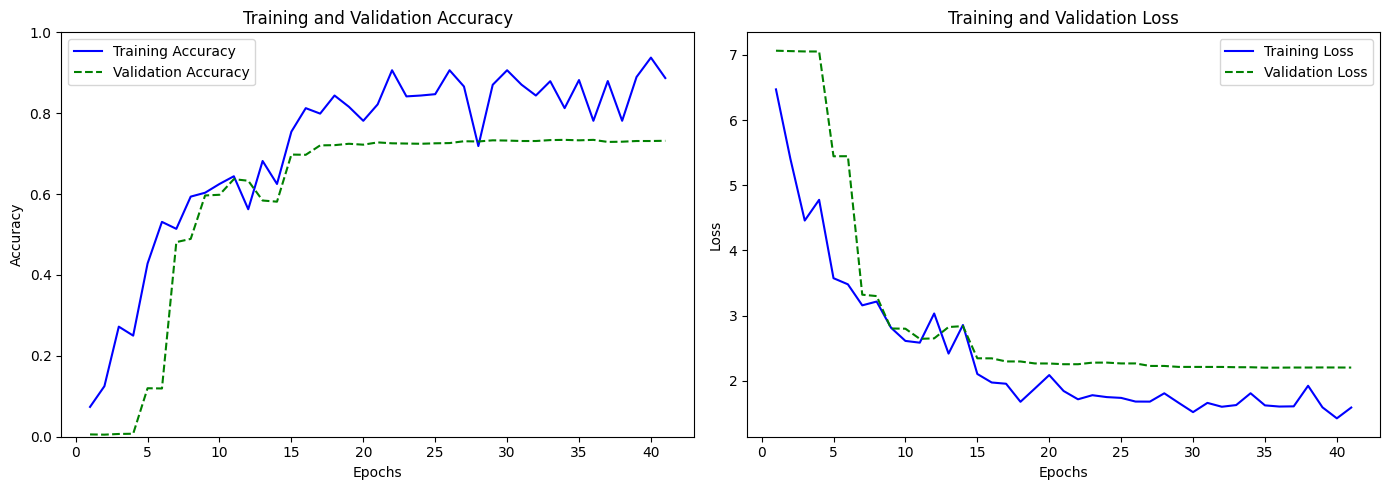

In [ ]:
plot_training(history1)

#Model evaluation

In [ ]:
#Evaluate the model on test_dataset
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Applied_ML_Assignment01/COS30082_Assignment1_model_unfreeze.keras')

In [ ]:
y_pred = model.predict(test_dataset)
y_true = test_dataset.classes

56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 199ms/step


In [ ]:
y_pred_labels = np.argmax(y_pred, axis=1)

In [ ]:
top1_accuracy = accuracy_score(y_true, y_pred_labels)
print(f"Top-1 Accuracy: {top1_accuracy * 100:.2f}%")

Top-1 Accuracy: 74.73%


In [ ]:
report = classification_report(y_true, y_pred_labels, target_names = classes_df['class_name'].tolist())
print(report)

                                precision    recall  f1-score   support

        Black_footed_Albatross       1.00      0.67      0.80         9
              Laysan_Albatross       0.88      0.78      0.82         9
               Sooty_Albatross       0.36      0.44      0.40         9
             Groove_billed_Ani       1.00      0.86      0.92         7
                Crested_Auklet       0.22      0.22      0.22         9
                  Least_Auklet       0.33      0.33      0.33         9
               Parakeet_Auklet       0.62      0.89      0.73         9
             Rhinoceros_Auklet       0.67      0.57      0.62         7
              Brewer_Blackbird       0.89      0.89      0.89         9
          Red_winged_Blackbird       0.40      0.67      0.50         9
               Rusty_Blackbird       1.00      0.89      0.94         9
       Yellow_headed_Blackbird       1.00      0.89      0.94         9
                      Bobolink       1.00      1.00      1.00  

#Performing test on random bird images

In [ ]:
test_data = ImageDataGenerator(
    rescale = 1./255
)

test_img_path = '/content/drive/MyDrive/COS30082_image_files/model_testing_img'

In [ ]:
test_filenames = os.listdir(test_img_path)
test_df = pd.DataFrame({
    "filename": test_filenames,
    "class_label": ["unknown"] * len(test_filenames)  # Dummy labels
})


In [ ]:
img_test_generator = test_data.flow_from_dataframe(
    dataframe=test_df,
    directory=test_img_path,
    x_col="filename",
    y_col="class_label",
    target_size=img_size,
    batch_size=1,
    class_mode=None,   # No labels
    shuffle=False
)

Found 14 validated image filenames.


In [ ]:
class_indices = train_dataset.class_indices
label_to_name = {v: k for k, v in class_indices.items()}

In [ ]:
predictions = model.predict(img_test_generator, steps = 200, verbose = 1 )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [ ]:
predicted_indices = np.argmax(predictions, axis=1)


In [ ]:
predicted_class_names = [label_to_name[int(i)] for i in predicted_indices]


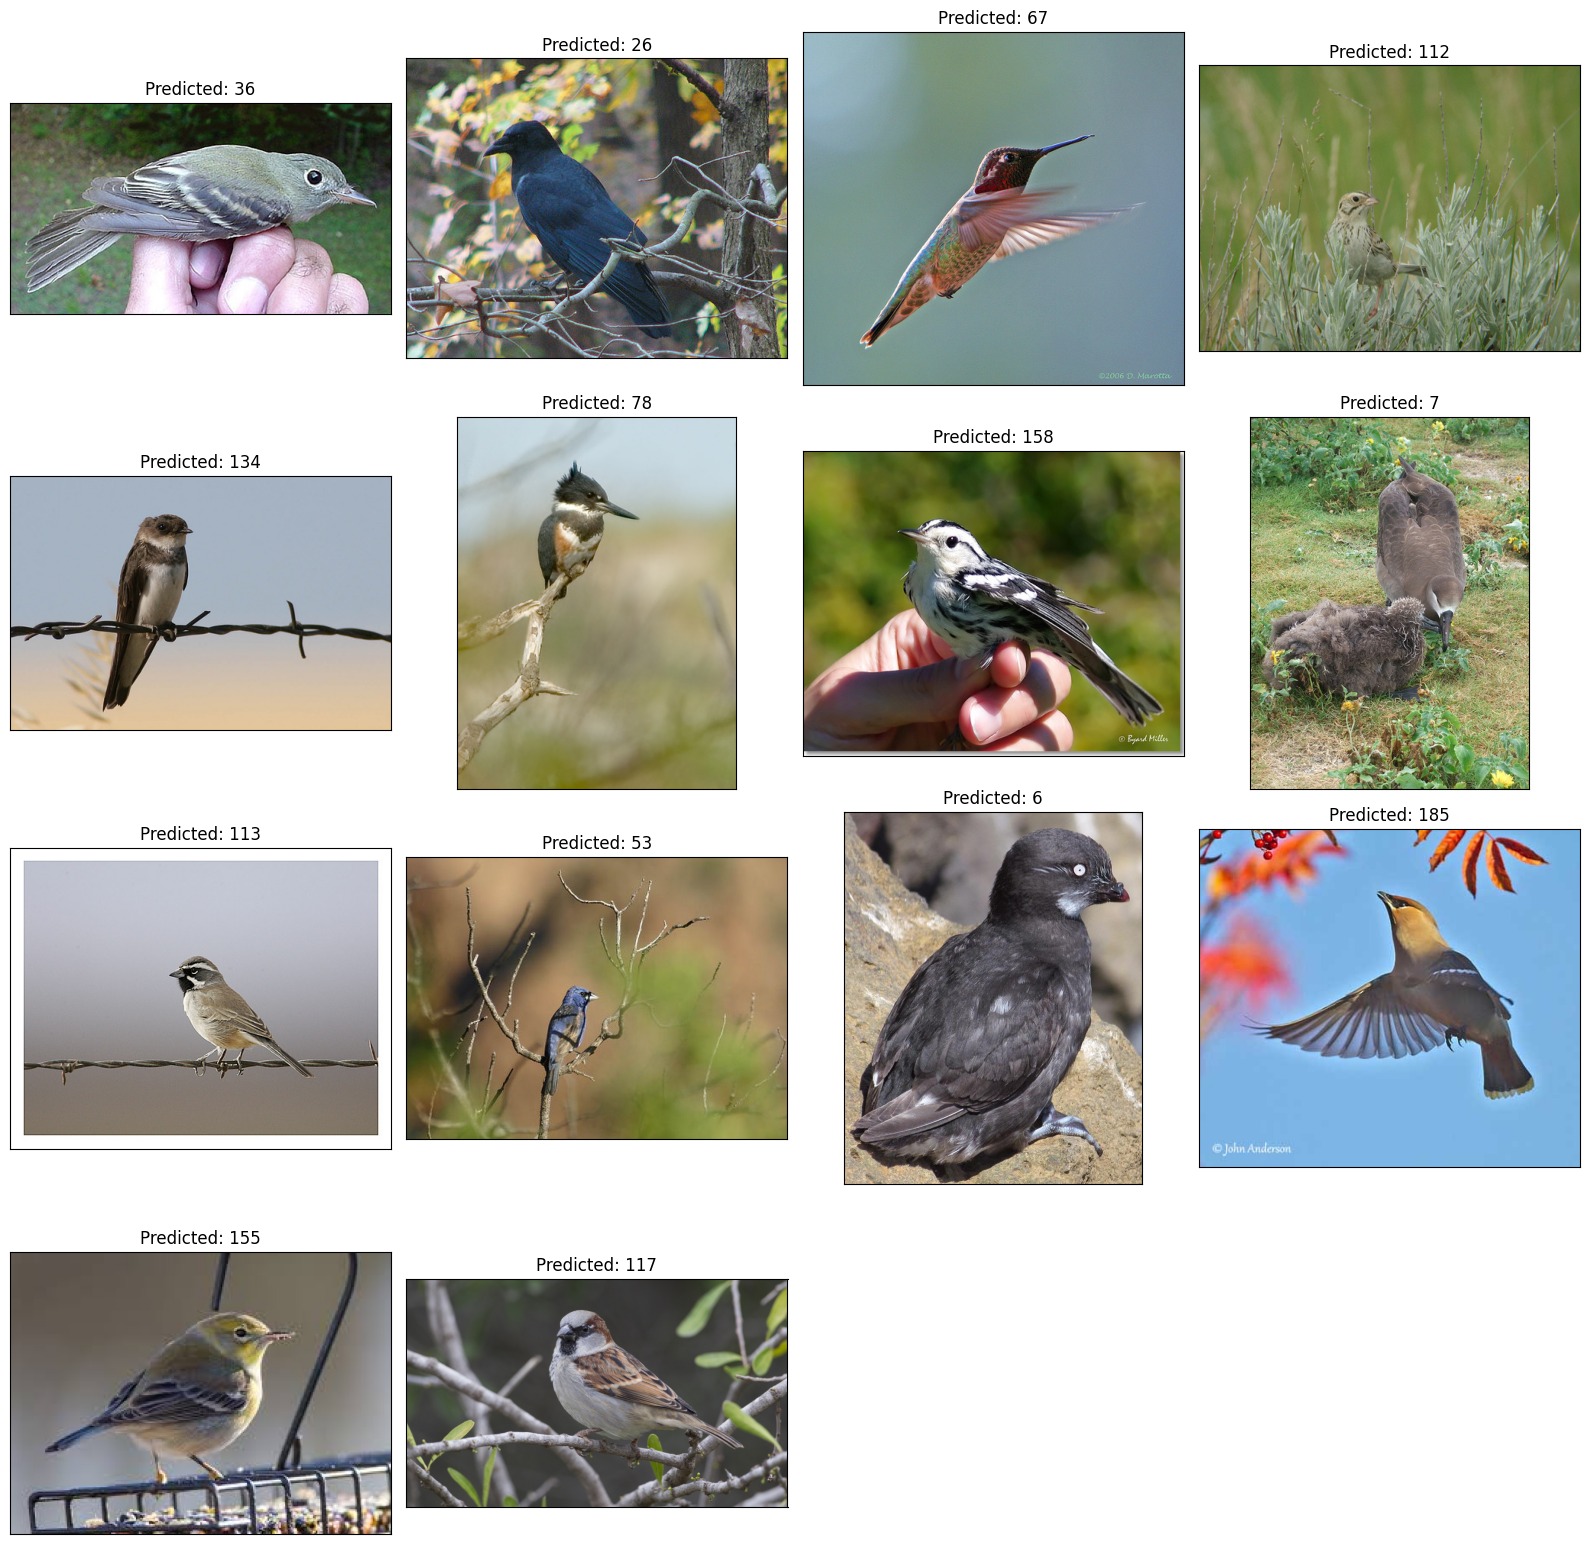

In [ ]:
import math

# Total number of test images
num_images = len(test_filenames)

# Define grid size (e.g., 4 columns)
cols = 4
rows = math.ceil(num_images / cols)

# Plot all images
plt.figure(figsize=(4 * cols, 4 * rows))
for i in range(num_images):
    img = plt.imread(os.path.join(test_img_path, test_filenames[i]))
    plt.subplot(rows, cols, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class_names[i]}')

plt.tight_layout()
plt.show()

In [ ]:
for i, name in enumerate(predicted_class_names):
    print(f"Image {i} ({test_filenames[i]}): Predicted class: {name}")

Image 0 (Acadian_Flycatcher.jpg): Predicted class: 36
Image 1 (American_Crow.jpg): Predicted class: 26
Image 2 (Anna_Hummingbird.jpg): Predicted class: 67
Image 3 (Baird_Sparrow.jpg): Predicted class: 112
Image 4 (Bank_Swallow.jpg): Predicted class: 134
Image 5 (Belted_Kingfisher.jpg): Predicted class: 78
Image 6 (Black_and_white_Warbler.jpg): Predicted class: 158
Image 7 (Black_footed_Albatross.jpg): Predicted class: 7
Image 8 (Black_throated_Sparrow.jpg): Predicted class: 113
Image 9 (Blue_Grosbeak.jpg): Predicted class: 53
Image 10 (Least_Auklet.jpg): Predicted class: 6
Image 11 (Bohemian_Waxwing.jpg): Predicted class: 185
Image 12 (Pine_Warbler.jpg): Predicted class: 155
Image 13 (House_Sparrow.jpg): Predicted class: 117


Img1<br>
Actual class: 28<br>
Predicted class: 26<br>
<br>
Img2
Actual class: 66<br>
Predicted class: 67

<br>
Img7
<br>
Actual class: 0<br>
Predicted class: 7

<br>
Img9<br>
Actual class: 28<br>
Predicted class: 26<br>

<br>
Img10<br>
Actual class: 5
Predicted class: 6
<br>
Img11<br>
Actuall class: 184<br>
Predicted class: 185<br>
Img12<br>
Actcual class: 174<br>
Predicted class: 155<br>




In [ ]:
unique_classes

class_name class_label
0              Black_footed_Albatross           0
60                   Laysan_Albatross           1
120                   Sooty_Albatross           2
178                 Groove_billed_Ani           3
238                    Crested_Auklet           4
282                      Least_Auklet           5
323                   Parakeet_Auklet           6
376                 Rhinoceros_Auklet           7
424                  Brewer_Blackbird           8
483              Red_winged_Blackbird           9
543                   Rusty_Blackbird          10
603           Yellow_headed_Blackbird          11
659                          Bobolink          12
719                    Indigo_Bunting          13
779                    Lazuli_Bunting          14
837                   Painted_Bunting          15
895                          Cardinal          16
952                   Spotted_Catbird          17
997                      Gray_Catbird          18
1056             Yellow_breasted_Chat          19
1115                   Eastern_Towhee          20
1175                 Chuck_will_Widow          21
1231                 Brandt_Cormorant          22
1290              Red_faced_Cormorant          23
1342                Pelagic_Cormorant          24
1402                  Bronzed_Cowbird          25
1462                    Shiny_Cowbird          26
1522                    Brown_Creeper          27
1581                    American_Crow          28
1641                        Fish_Crow          29
1701              Black_billed_Cuckoo          30
1761                  Mangrove_Cuckoo          31
1814             Yellow_billed_Cuckoo          32
1873          Gray_crowned_Rosy_Finch          33
1932                     Purple_Finch          34
1992                 Northern_Flicker          35
2052               Acadian_Flycatcher          36
2111         Great_Crested_Flycatcher          37
2171                 Least_Flycatcher          38
2230           Olive_sided_Flycatcher          39
2290        Scissor_tailed_Flycatcher          40
2350             Vermilion_Flycatcher          41
2410        Yellow_bellied_Flycatcher          42
2469                      Frigatebird          43
2529                  Northern_Fulmar          44
2589                          Gadwall          45
2649               American_Goldfinch          46
2709               European_Goldfinch          47
2769              Boat_tailed_Grackle          48
2829                      Eared_Grebe          49
2889                     Horned_Grebe          50
2949                Pied_billed_Grebe          51
3009                    Western_Grebe          52
3069                    Blue_Grosbeak          53
3129                 Evening_Grosbeak          54
3189                    Pine_Grosbeak          55
3249           Rose_breasted_Grosbeak          56
3309                 Pigeon_Guillemot          57
3367                  California_Gull          58
3427             Glaucous_winged_Gull          59
3486                    Heermann_Gull          60
3546                     Herring_Gull          61
3606                       Ivory_Gull          62
3666                 Ring_billed_Gull          63
3726                Slaty_backed_Gull          64
3776                     Western_Gull          65
3836                 Anna_Hummingbird          66
3896        Ruby_throated_Hummingbird          67
3956               Rufous_Hummingbird          68
4016                  Green_Violetear          69
4076               Long_tailed_Jaeger          70
4136                  Pomarine_Jaeger          71
4196                         Blue_Jay          72
4256                      Florida_Jay          73
4316                        Green_Jay          74
4373                  Dark_eyed_Junco          75
4433                Tropical_Kingbird          76
4493                    Gray_Kingbird          77
4552                Belted_Kingfisher          78
4612                 Green_